# Supporting Code

### import libraries

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import zipfile
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from copy import copy

### helper functions and classes

In [4]:
# Function to extract and parse XML from a zip file
def extract_and_parse_xml(zip_path, file_name):
    # use the xipfile library to get the content => https://docs.python.org/3/library/zipfile.html
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open(file_name) as xml_file:
            # Read the content of the file
            xml_content = xml_file.read()
            # Parse the XML to a python object => https://docs.python.org/3/library/xml.etree.elementtree.html
            root = ET.fromstring(xml_content)
    return root

In [6]:
# helper to find a specific row in the tournament summary file
def find_row(filepath, content):
    with open(filepath, 'r') as file:
        for i, line in enumerate(file):
            if content in line:
                return i
    return -1

# define search terms globally, they are standard for all tournaments
# this tells us where the list of games begins
header_content = 'iteration\tmap\tai1\tai2\ttime\twinner\tcrashed\ttimedout'
# this tells us where the list of models ends
maps_header_content = 'maps'
# this tells us where the footer starts. If the tournament was force-stopped, there will be no footer
footer_start = 'Wins:'

### Main Tournament Analysis Class

In [154]:
# class to define an object containing tournament traces
class TournamentAnalysis:

    #### CONSTRUCTOR ####
    # loads games and traces of the of the tournament
    def __init__(self, name, fraction=1.0):
        self.name = name
        
        # the path to the tournament summary file
        tournament_summary_file = 'C:/source/MicroRTS/' + name + '/tournament.csv'
   
        # Find the number of models used in this tournament
        n_models = find_row(tournament_summary_file, maps_header_content) - 2
        
        # read in the model names
        ai_models = pd.read_table(tournament_summary_file, usecols=[1], sep='\t', skiprows=1, nrows=n_models)
        ai_models_list = ai_models.iloc[:,0].tolist()
        # create a dict so we can use map()
        model_names_dict = {i: name.split('(')[0] for i, name in enumerate(ai_models_list)}
        
        # Find the row number of the header
        header_row = find_row(tournament_summary_file, header_content)

        # calculate the length of the footer in the tournament file
        footer_length = 0
        if (find_row(tournament_summary_file, footer_start) != -1):
            footer_length = (n_models * 7) + 7
            
        # load the tournament summary into a dataframe
        df_games = pd.read_table(tournament_summary_file, sep='\t', skiprows=header_row, skipfooter=footer_length, engine='python')

        # Truncate he dataframe to the proportion provided by the user
        max_rows = int(len(df_games) * fraction)
        df_games = df_games.iloc[:max_rows]
     
        # add the model names to the dataframe
        df_games['ai1_name'] = df_games['ai1'].map(model_names_dict)
        df_games['ai2_name'] = df_games['ai2'].map(model_names_dict)
        
        # winner columns, so we know which column won
        df_games['winning_model'] = np.where(df_games['winner'] == 0, df_games['ai1'], np.where(df_games['winner'] == 1, df_games['ai2'], -1))
        df_games['winning_model_name'] = df_games['winning_model'].map(model_names_dict)
        # loser columns, so we know which model was beaten
        df_games['losing_model'] = np.where(df_games['winner'] == 0, df_games['ai2'], np.where(df_games['winner'] == 1, df_games['ai2'], -1))
        df_games['losing_model_name'] = df_games['losing_model'].map(model_names_dict)

        # Initialize list to hold trace data
        trace_data = []
        # the path where traces are stored
        traces_path = 'C:/source/MicroRTS/' + self.name + '/traces/'
        
        # loop through all games in the tournament summary
        for index, row in df_games.iterrows():
        
            # compose the filename where the traces for this game will be stored
            filename = "%d-vs-%d-%d-%d.zip" % (row['ai1'], row['ai2'], row['map'], row['iteration']) 
            # Load the XML file
            root = extract_and_parse_xml(traces_path + filename, 'game.xml')
            
            # Iterate through each TraceEntry to extract timestep data
            for entry in root.findall('.//rts.TraceEntry'):
                # timestep ID if this TraceEntry in the game
                time = int(entry.get('time'))
                
                # Extract players' data
                players = entry.findall('.//rts.Player')
                player_data = {f"player_{player.get('ID')}_resources": int(player.get('resources')) for player in players}
                
                # Initialize counters for unit types
                unit_counts = defaultdict(int)
                
                # Extract units - count unit types for each player
                units = entry.findall('.//rts.units.Unit')
                for unit in units:
                    unit_type = unit.get('type')
                    player_id = unit.get('player')
                    if player_id != '-1':  # Exclude neutral units like resources
                        unit_counts[f"player_{player_id}_{unit_type}_units"] += 1
                
                # Extract actions' data
                action_counts = defaultdict(int)
                # get an array of action tags
                actions = entry.findall('.//action')
                # loop through each action
                for action in actions:
                    # the unit that the action was performed on
                    unit_id = action.get('unitID')
                    # the action that was performed
                    unit_action = action.find('UnitAction')
                    # if an action was defined
                    if unit_action is not None:
                        # action details
                        action_type = unit_action.get('type')
                        parameter = unit_action.get('parameter')
                        for unit in units:
                            if unit.get('ID') == unit_id:
                                player_id = unit.get('player')
                                break
                        # create columns for player and action type, or player and parameter
                        action_counts[f"player_{player_id}_action_type_{action_type}_count"] += 1
                        action_counts[f"player_{player_id}_action_parameter_{parameter}_count"] += 1
                
                # Combine data for this timestep
                timestep_data = {'time': time}
                timestep_data.update(player_data)
                timestep_data.update(unit_counts)
                timestep_data.update(action_counts)
        
                # add label columns
                timestep_data['opponent'] = row['ai2_name']
                timestep_data['game_id'] = filename
                
                # Add to data list of traces
                trace_data.append(timestep_data)
        
        # Create DataFrame from the traces
        df = pd.DataFrame(trace_data)
        
        # Fill NaN values with 0 (in case there are no actions of certain types in some timesteps)
        df = df.fillna(0)

        # Set properties on this object
        self.games = df_games
        self.models = model_names_dict
        self.model_names = ai_models_list
        self.traces = df  
        self.n_models = n_models
    
    #### PREPROCESSING ####
    # preprocesses data into sliding windows and train-test split
    def preprocess(self, window_size = 5, test_size=0.2):
        X, y = [], []
        i = 0
        self.window_size = window_size
        df = self.traces
        # loop through the timestep data
        while i < len(df) - window_size:
            # make sure the next N traces are within the same game (don't want to mix games in a window)
            if df.iloc[i]['game_id'] == df.iloc[i + window_size]['game_id']:
                # Take take N traces at a time
                window = df.iloc[i:i + window_size]
                X.append(window.drop(columns=['time', 'game_id', 'opponent']).values)
                # Use the opponent label at the end of the window
                y.append(window['opponent'].iloc[-1])
                # increment i to make a sliding window starting with the next
                i += 1
            else:
                # we need to skip to start a new window at the next different value
                i = i + window_size - 1

        X = np.array(X)
        self.X_unflat = X
        self.X_columns = [col for col in self.traces.columns if col not in ['opponent', 'time', 'game_id']]
        self.y = np.array(y)

        # Encode the opponent labels
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)

        # We need to flatten the X array for Scikit-Learn
        num_samples, window_size, num_features = X.shape
        # Flatten each window
        self.X = np.array([window.flatten() for window in X])
        
        # Split the data into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=42, stratify=self.y)

    #### TRAIN ####
    def train(self):
        # Initialize the classifier
        self.classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        
        # Train the classifier
        self.classifier.fit(self.X_train, self.y_train)

    #### EVALUATE ####
    def evaluate(self, X_test, y_test):
        # Make predictions on the test set
        y_pred = self.classifier.predict(X_test)
        # Evaluate performance
        print("Overall accuracy:", accuracy_score(y_test, y_pred))
        print("Report:")
        print(classification_report(y_test, y_pred, target_names=self.label_encoder.classes_))
        return y_pred

    #### CLUSTERING ####
    
    def elbowForOptimalK(self, max=10, figsize=(10, 5)):
        # Determine the optimal number of clusters using the elbow method
        wcss = []
        for i in range(1, max):
            kmeans = KMeans(n_clusters=i, random_state=42)
            kmeans.fit(self.X)
            wcss.append(kmeans.inertia_)
        
        # Plot the elbow graph
        plt.figure(figsize=figsize)
        plt.plot(range(1, max), wcss, marker='o')
        plt.title('Elbow Method For Optimal k')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.show()

    def cluster(self, k_clusters, figsize=(10, 5)):
        # set local variables to use for clustering
        df = self.traces
        X_flat = self.X
        
        # Fit K-Means with the optimal number of clusters
        kmeans = KMeans(n_clusters=k_clusters, random_state=42)
        y_kmeans = kmeans.fit_predict(X_flat)
        self.y_kmeans = y_kmeans
        self.k_clusters = k_clusters
                
        # Add a column for cluster labels to the dataframe
        df['cluster'] = np.nan
        
        # Ensure the cluster labels are assigned correctly
        for i in range(len(y_kmeans)):
            df.iloc[i:i + self.window_size, df.columns.get_loc('cluster')] = y_kmeans[i]
        
        # Calculate PCA component to graph the clusters in 2d
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_flat)

        # plot the cluster diagram
        plt.figure(figsize=figsize)
        for cluster in np.unique(y_kmeans):
            color = plt.cm.nipy_spectral(float(cluster) / len(np.unique(y_kmeans)))
            label = f'Cluster {cluster}'
            plt.scatter(X_pca[y_kmeans == cluster, 0], X_pca[y_kmeans == cluster, 1], color=color, label=label)
        plt.title('K-Means Clusters of Opponents')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend()
        plt.show()
        

    def clusterBarchart(self, k_clusters, figsize=(10, 7)):        
        # Encode the opponent column
        label_encoder_opponent = LabelEncoder()
        opponent_encoded = label_encoder_opponent.fit_transform(self.y)
        opponent_names = label_encoder_opponent.inverse_transform(opponent_encoded)
        
        # Truncate opponent names at the first opening bracket "("
        truncated_opponent_names = [name.split('(')[0].strip() for name in opponent_names]
        
        # Create a DataFrame with opponent and cluster labels
        cluster_df = pd.DataFrame({'opponent': truncated_opponent_names, 'cluster': self.y_kmeans})
        
        # Create a pivot table for the stacked bar chart
        pivot_table = cluster_df.pivot_table(index='opponent', columns='cluster', aggfunc=len, fill_value=0)
        
        # Plot the stacked bar chart
        pivot_table.plot(kind='bar', stacked=True, colormap='tab10', figsize=figsize)
        
        plt.title('Distribution of Clusters Across Opponents')
        plt.xlabel('Opponent')
        plt.ylabel('Number of Samples')
        plt.legend(title='Cluster')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def clusterByOpponent(self, k_clusters):
        df = self.traces
        X_flat = self.X
        y = self.y
        
        # Encode the opponent column
        label_encoder_opponent = LabelEncoder()
        opponent_encoded = label_encoder_opponent.fit_transform(y)
        
        # Fit K-Means with the optimal number of clusters
        kmeans = KMeans(n_clusters=k_clusters, random_state=42)
        y_kmeans = kmeans.fit_predict(X_flat)
        self.y_kmeans = y_kmeans
        
        # Ensure the lengths of X_flat and y_kmeans are the same
        assert len(X_flat) == len(y_kmeans), "Mismatch in number of samples between X_flat and y_kmeans"
        assert len(y_kmeans) == len(opponent_encoded), "Mismatch in number of samples between y_kmeans and opponent_encoded"
        
        # Add the cluster labels to the original dataframe
        df['cluster'] = np.nan
        
        # Ensure the cluster labels are assigned correctly
        for i in range(len(y_kmeans)):
            df.iloc[i:i + self.window_size, df.columns.get_loc('cluster')] = y_kmeans[i]
        
        # Reduce dimensionality for visualization
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_flat)
        
        # Plot each opponent separately
        unique_opponents = np.unique(opponent_encoded)
        colors = plt.cm.get_cmap('tab10', k_clusters)
        
        for opponent in unique_opponents:
            mask = opponent_encoded == opponent
            opponent_name = label_encoder_opponent.inverse_transform([opponent])[0]
            
            plt.figure(figsize=(12, 8))
            for cluster in np.unique(y_kmeans):
                cluster_mask = (y_kmeans == cluster) & mask
                plt.scatter(
                    X_pca[cluster_mask, 0], 
                    X_pca[cluster_mask, 1], 
                    color=colors(cluster), 
                    label=f'Cluster {cluster}'
                )
            
            plt.title(f'K-Means Clusters for Opponent: {opponent_name}')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            plt.legend()
            plt.show()

    def GetXByCluster(self, n):
        # Get the indices of the rows that belong to cluster 2
        cluster_indices = np.where(self.y_kmeans == n)[0]
        
        # Extract the rows corresponding to cluster 2 from X_flat
        return self.X_unflat[cluster_indices]
        
        # TO DO: create a DataFrame for easier analysis
        #df_cluster_2 = pd.DataFrame(X_cluster_2, columns=[f"feature_{i}" for i in range(X_flat.shape[1])])

    def ClusterTraceChart(self, n, figsize=(10, 8)):
        traces = self.GetXByCluster(n)
        print(traces.shape)

        # Exclude the two columns related to player total resources
        column_names_filtered = self.X_columns[2:-1]
        X_filtered = traces[:,:, 2:-1]
        
        # Sum the values across all windows and timesteps for each column
        #column_sums = X_filtered.sum(axis=(0, 1))
        
        # Calculate the average for each column
        column_averages = X_filtered.mean(axis=(0, 1))
        
        # Plotting the horizontal bar chart
        plt.figure(figsize=figsize)
        y_pos = np.arange(len(column_names_filtered))
        
        plt.barh(y_pos, column_averages, align='center', alpha=0.7, label='Sum')
        #plt.plot(column_averages, y_pos, 'r--', label='Average', marker='o')
        
        # Add inline labels for the average values
        for i, avg in enumerate(column_averages):
            plt.text(avg, y_pos[i], f'            avg: {avg:.2f}', color='red', va='center', ha='left', fontsize=9)
        
        # Add labels and title
        plt.yticks(y_pos, column_names_filtered)
        plt.xlabel('Sum of Values')
        plt.title('Sum of Each Column with Average Trend Line')
        
        # Add a legend
        plt.legend()
        
        # Display the plot
        plt.tight_layout()
        plt.show()

    def AttributeSumByCluster(self, columns, figsize=(8, 4)):
        
        # Get unique clusters from y_kmeans
        unique_clusters = np.unique(self.y_kmeans)
        
        indices = [list(self.X_columns).index(col) for col in columns]        
        
        # Initialize a dictionary to store sums for each column and cluster
        cluster_column_sums = {col: [] for col in indices}
        
        # Iterate over each unique cluster
        for cluster in unique_clusters:
            # Select rows of X_unflat corresponding to the current cluster
            cluster_data = self.X_unflat[self.y_kmeans == cluster]
            
            # Calculate the sum for each specified column in the cluster and store it
            for col_index in indices:
                col_sum = cluster_data[:, :, col_index].sum()
                cluster_column_sums[col_index].append(col_sum)
        
        # Plot the results
        fig, ax = plt.subplots(figsize=figsize)
        bar_width = 0.2
        x = np.arange(len(unique_clusters))
        
        # Plot a bar for each column
        for i, col_index in enumerate(indices):
            ax.bar(x + i * bar_width, cluster_column_sums[col_index], width=bar_width, label=f'{self.X_columns[col_index]}')
        
        # Set labels and title
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Sum of Column Values')
        ax.set_title('Sum of Selected Columns Grouped by Cluster')
        ax.set_xticks(x + bar_width * (len(indices) - 1) / 2)
        ax.set_xticklabels(unique_clusters)
        ax.legend()
        
        # Show the plot
        plt.show()

    def AttributeAvgByCluster(self, columns, figsize=(8, 4)):
        
        # Get unique clusters from y_kmeans
        unique_clusters = np.unique(self.y_kmeans)
        indices = [list(self.X_columns).index(col) for col in columns]        
        
        # Initialize a dictionary to store sums for each column and cluster
        cluster_column_averages = {col: [] for col in indices}
        
        # Iterate over each unique cluster
        for cluster in unique_clusters:
            # Select rows of X_unflat corresponding to the current cluster
            cluster_data = self.X_unflat[self.y_kmeans == cluster]
            
            # Calculate the average for each specified column in the cluster and store it
            for col_index in indices:
                col_average = cluster_data[:, :, col_index].mean()
                cluster_column_averages[col_index].append(col_average)
        
        # Plot the results
        fig, ax = plt.subplots(figsize=figsize)
        bar_width = 0.2
        x = np.arange(len(unique_clusters))

        
        # Modify column names for the legend
        modified_labels = [
            self.X_columns[col_index].replace("player_1_action_", "").replace("_count", "")
            for col_index in indices
        ]
        
        # Plot a bar for each column
        for i, col_index in enumerate(indices):
            ax.bar(x + i * bar_width, cluster_column_averages[col_index], width=bar_width, label=modified_labels[i])
        
        # Set labels and title
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Average value per sample')
        ax.set_title('Average value of column by cluster')
        ax.set_xticks(x + bar_width * (len(indices) - 1) / 2)
        ax.set_xticklabels(unique_clusters)
        ax.legend()  
        # Show the plot
        plt.show()

    ### MISC Analysis

    def PlotGameLength(self, bins = [0, 50, 100, 250, 500, 1000, 2000, 3000], figsize=(8, 4)):
        
        # Create time bins using pd.cut
        self.games['time_bins'] = pd.cut(self.games['time'], bins=bins)
        
        # Group by the 'time_bins' and count occurrences
        grouped = self.games['time_bins'].value_counts(sort=False)
    
        # Plot the bar chart
        grouped.plot(kind='bar', figsize=figsize, color='skyblue', edgecolor='black')
    
        # Add labels and title
        plt.title('Number of Games by Duration')
        plt.xlabel('Game Duration (timesteps range)')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
        plt.grid(axis='y')
    
        # Show the plot
        plt.show()

    def GameLengthByOpponent(self, bins = [0, 50, 100, 250, 500, 1000, 2000, 3000], figsize=(8, 4)):
        
        # Define the bins for time (e.g., you can modify the ranges to fit your data better)
        self.games['time_bins'] = pd.cut(self.games['time'], bins=bins)  # Create time bins
        
        # Group by the 'time_bins' and 'ai2_name' columns, and count occurrences
        grouped = self.games.groupby(['time_bins', 'ai2_name']).size().unstack(fill_value=0)
        
        # Plot the stacked bar chart
        grouped.plot(kind='bar', stacked=True, figsize=figsize, colormap='tab20')
        
        # Add labels and title
        plt.title('Number of Games by Duration and Opponent')
        plt.xlabel('Game Duration (timesteps range)')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
        plt.legend(title='Opponent')
        plt.grid(axis='y')
        
        # Show the plot
        plt.show()

    def PlotGameOpponent(self, figsize=(8, 4)):
        
        # Count the occurrences of each value in 'ai2_name'
        ai2_name_counts = self.games['ai2_name'].value_counts()
        
        # Create a bar chart
        plt.figure(figsize=figsize)
        ai2_name_counts.plot(kind='bar', color='skyblue', edgecolor='black')
        
        # Add labels and title
        plt.title('Games by Opponent')
        plt.xlabel('Opponent')
        plt.ylabel('No. of Games')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
        plt.grid(axis='y')
        
        # Show the plot
        plt.show()
    
    def PlotTraceOpponent(self, figsize=(8, 4)):
        
        # Count the occurrences of each value in 'ai2_name'
        ai2_name_counts = self.traces['opponent'].value_counts()
        
        # Create a bar chart
        plt.figure(figsize=figsize)
        ai2_name_counts.plot(kind='bar', color='skyblue', edgecolor='black')
        
        # Add labels and title
        plt.title('Traces by Opponent')
        plt.xlabel('Opponent')
        plt.ylabel('No. of Traces')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
        plt.grid(axis='y')
        
        # Show the plot
        plt.show()

# Experiments

### tournament 12

In [ ]:
%%time
t12 = TournamentAnalysis("tournament_12")

In [ ]:
%%time
t13 = TournamentAnalysis("tournament_13")

In [ ]:
%%time
t12.preprocess()

In [ ]:
%%time
t13.preprocess()

In [ ]:
%%time
t12.train()

In [ ]:
%%time
t13.train()

In [ ]:
t12.evaluate(t12.X_test, t12.y_test)

In [ ]:
t13.evaluate(t13.X_test, t13.y_test)

In [ ]:
%%time
t12.elbowForOptimalK()

In [ ]:
%%time
t13.elbowForOptimalK()

In [ ]:
t12.cluster(3);

In [ ]:
t12.clusterBarchart(3);

In [ ]:
t12.ClusterTraceChart(2)

In [ ]:
a = t12.ClusterTraceChart(1)

In [ ]:
len(a[0][0])

In [ ]:
len(t12.X[0])

In [ ]:
t12.traces.head()

In [ ]:
t13.cluster(4);

In [ ]:
t12.cluster(2);

In [ ]:
t13.cluster(2);

In [ ]:
t12.clusterByOpponent(4)

In [ ]:
t13.clusterByOpponent(4)

In [ ]:
t12.clusterByOpponent(2)

In [ ]:
t13.models

### ==== END tournament 12

In [ ]:
%%time
t7 = TournamentAnalysis("tournament_7")

In [ ]:
%%time
t7.preprocess()

In [ ]:
%%time
t7.train()

In [ ]:
t7.evaluate(t7.X_test, t7.y_test)

In [ ]:
%%time
t5 = TournamentAnalysis("tournament_5")

In [ ]:
%%time
t5.preprocess()

In [ ]:
%%time
t5.train()

In [ ]:
%%time
t5.evaluate(t5.X_test, t5.y_test)

In [ ]:
t5.models

### Tournament 8 - 8 models, 25 iterations

In [ ]:
%%time
# load tournament info
tournament_8 = TournamentAnalysis("tournament_8")

In [ ]:
%%time
# preprocess the data
tournament_8.preprocess(8)

In [ ]:
%%time
tournament_8.train()

In [ ]:
%%time
# evaluate the model trained on this tournament
tournament_8.evaluate(tournament_8.X_test, tournament_8.y_test)

### Tournament 10 - 5 models, 25 iterations

In [ ]:
%%time
# load tournament info
tournament_10 = TournamentAnalysis("tournament_10", 0.1)

In [ ]:
# view the models in the tournament
tournament_10.models

In [ ]:
%%time
# preprocess the data
tournament_10.preprocess()

In [ ]:
%%time
tournament_10.train()

In [ ]:
%%time
# evaluate the model trained on this tournament
tournament_10.evaluate(tournament_10.X_test, tournament_10.y_test)

In [ ]:
# loop throuh the CoacAI games from tournament 10 and predict them
for i in range (10):
    if(tournament_10.X[i][7] == 0):
        print(tournament_8.classifier.predict(tournament_10.X))

In [ ]:
%%time
tournament_10 = TournamentAnalysis("tournament_10")
tournament_10.preprocess()
tournament_10.elbowForOptimalK()

In [ ]:
tournament_10.models

In [ ]:
tournament_10.cluster(3)

In [ ]:
tournament_10.clusterByOpponent(3)

### Tournament 15

In [ ]:
%%time
t15 = TournamentAnalysis("tournament_15", 0.1)

In [ ]:
%%time
t15.preprocess()

In [ ]:
%%time
t15.train()

In [ ]:
t15.evaluate(t15.X_test, t12.y_test)

In [ ]:
%%time
t15.elbowForOptimalK()

In [ ]:
t15.cluster(5);

In [ ]:
t15.clusterBarchart(5);

In [ ]:
t15.ClusterTraceChart(1)

### Baseline Model Analysis

In [ ]:
%%time
t22 = TournamentAnalysis("tournament_22", 0.1)

In [ ]:
t22.PlotGameLength([0, 100, 200, 300, 400, 500, 1000, 2000, 3000], (6, 3))

In [ ]:
t22_1_10.PlotOppponent()

In [ ]:
%%time
t22.preprocess()

In [ ]:
%%time
t22.train()

In [ ]:
t22.evaluate(t22.X_test, t22.y_test)

In [14]:
%%time
t22_3 = TournamentAnalysis("tournament_22", 0.1)
t22_5 = copy(t22_3)
t22_10 = copy(t22_3)
t22_15 = copy(t22_3)

CPU times: total: 469 ms
Wall time: 34.2 s


In [15]:
%%time
t22_3.preprocess(2)
t22_5.preprocess(5)
t22_10.preprocess(10)
t22_15.preprocess(15)

CPU times: total: 13.4 s
Wall time: 5min 2s


In [16]:
%%time
t22_3.train()
t22_5.train()
t22_10.train()
t22_15.train()

CPU times: total: 20.4 s
Wall time: 2min 59s


In [17]:
%%time
t22_3.evaluate(t22_3.X_test, t22_3.y_test)
t22_5.evaluate(t22_5.X_test, t22_5.y_test)
t22_10.evaluate(t22_10.X_test, t22_10.y_test)
t22_15.evaluate(t22_15.X_test, t22_15.y_test)

Overall accuracy: 0.7323943661971831
Report:
                    precision    recall  f1-score   support

      HeavyDefense       0.73      0.74      0.73      5241
         HeavyRush       0.66      0.65      0.66      3936
      LightDefense       0.84      0.83      0.83      4675
         LightRush       0.73      0.83      0.78      3974
         PassiveAI       1.00      1.00      1.00      3137
          RandomAI       1.00      0.99      1.00      2069
     RangedDefense       0.56      0.51      0.53      3481
        RangedRush       0.60      0.58      0.59      3659
     WorkerDefense       0.93      0.93      0.93      4075
        WorkerRush       0.29      0.30      0.30      1589
WorkerRushPlusPlus       0.30      0.28      0.29      1581

          accuracy                           0.73     37417
         macro avg       0.69      0.69      0.69     37417
      weighted avg       0.73      0.73      0.73     37417

Overall accuracy: 0.7487190668265562
Report:
       

array(['LightDefense', 'HeavyDefense', 'WorkerRush', ..., 'LightRush',
       'HeavyDefense', 'LightDefense'], dtype='<U18')

In [ ]:
%%time
t22_1_5 = TournamentAnalysis("tournament_22")
t22_1_5.preprocess(5)

In [ ]:
%%time
t22_1_10.preprocess(10)

In [ ]:
%%time
t22_1_25.preprocess(25)

In [ ]:
%%time
t22_1_50.preprocess(50)

In [ ]:
%%time
t22_1_5.train()
t22_1_5.evaluate(t22_1_5.X_test, t22_1_5.y_test)

In [ ]:
t22_5.cluster(5)

In [ ]:
t22_5.clusterBarchart(5, (6, 4))

In [ ]:
t22_1_5.cluster(4)

In [ ]:
t22_1_5.cluster(4)
t22_1_5.clusterBarchart(4)

In [ ]:
t22_1_5.elbowForOptimalK()

In [ ]:
%%time
t22_1_10.train()

In [ ]:
%%time
t22_1_25.train()

In [ ]:
%%time
t22_1_50.train()

In [ ]:
%%time
t22_1_5.evaluate(t22_1_5.X_test, t22_1_5.y_test)
t22_1_10.evaluate(t22_1_10.X_test, t22_1_10.y_test)
t22_1_25.evaluate(t22_1_25.X_test, t22_1_25.y_test)
t22_1_50.evaluate(t22_1_50.X_test, t22_1_50.y_test)

In [ ]:
%%time
t22_1_100 = TournamentAnalysis("tournament_22", 0.2)
t22_1_200.PlotGameLength()
t22_1_100.preprocess(100)
t22_1_100.train()
t22_1_100.evaluate(t22_1_100.X_test, t22_1_100.y_test)

In [ ]:
%%time
t22_1_200 = TournamentAnalysis("tournament_22", 0.2)
t22_1_200.PlotGameLength()
t22_1_200.preprocess(200)
t22_1_200.train()
t22_1_200.evaluate(t22_1_200.X_test, t22_1_200.y_test)

## Tournament 24

In [164]:
%%time
tournament_24 = TournamentAnalysis("tournament_24", 0.5)

CPU times: total: 1min 5s
Wall time: 5min 29s


In [18]:
len(tournament_24.traces)

2101686

In [165]:
%%time
tournament_24.preprocess(15)

CPU times: total: 3min 43s
Wall time: 12min 17s


In [21]:
len(tournament_24.X)

2012099

In [ ]:
%%time
tournament_24.train()
tournament_24.evaluate(tournament_24.X_test, tournament_24.y_test)

In [ ]:
tournament_24.elbowForOptimalK(10, (8, 5))

C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


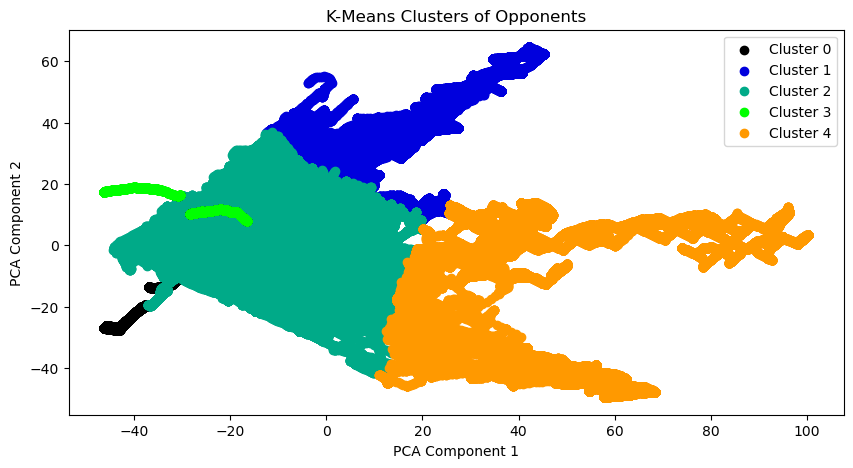

CPU times: total: 7min 48s
Wall time: 3min 19s


In [166]:
%%time
tournament_24.cluster(5)

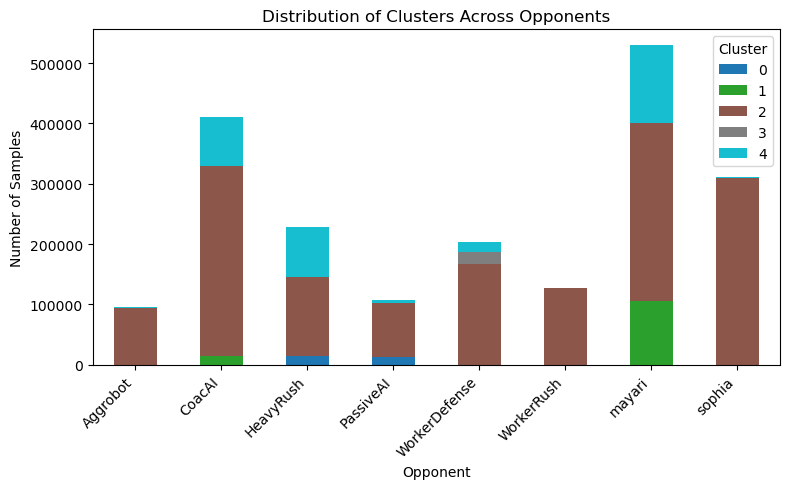

CPU times: total: 46.9 ms
Wall time: 2.45 s


In [103]:
%%time
tournament_24.clusterBarchart(5, (8, 5))

(119645, 15, 38)


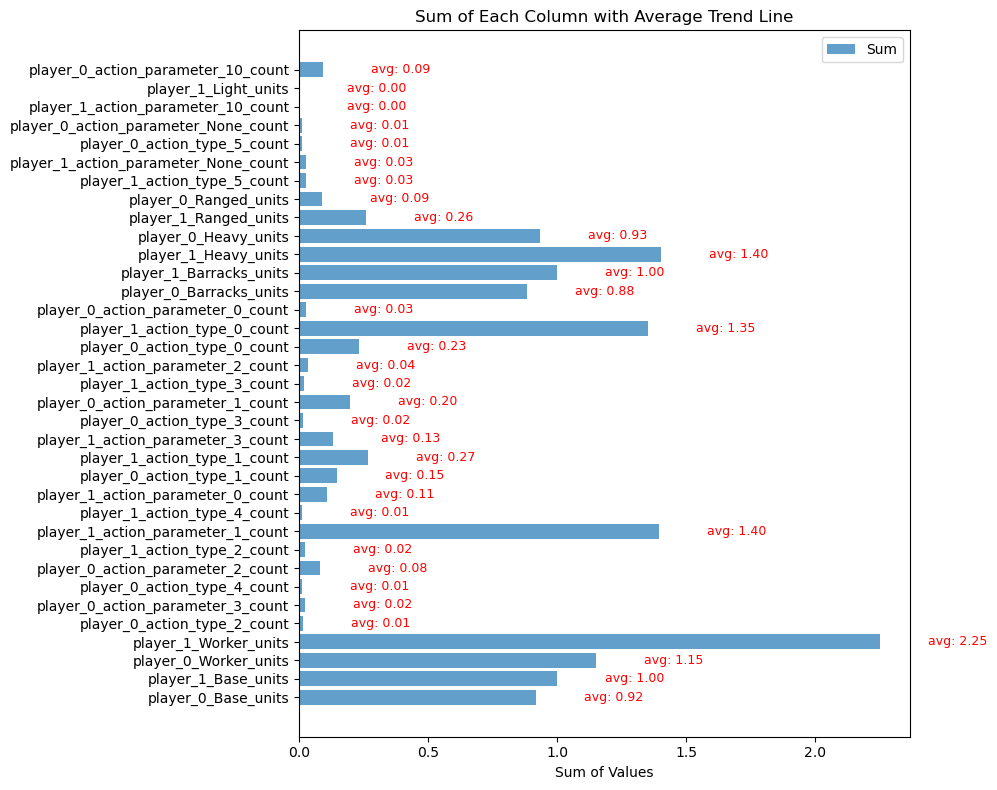

(1529727, 15, 38)


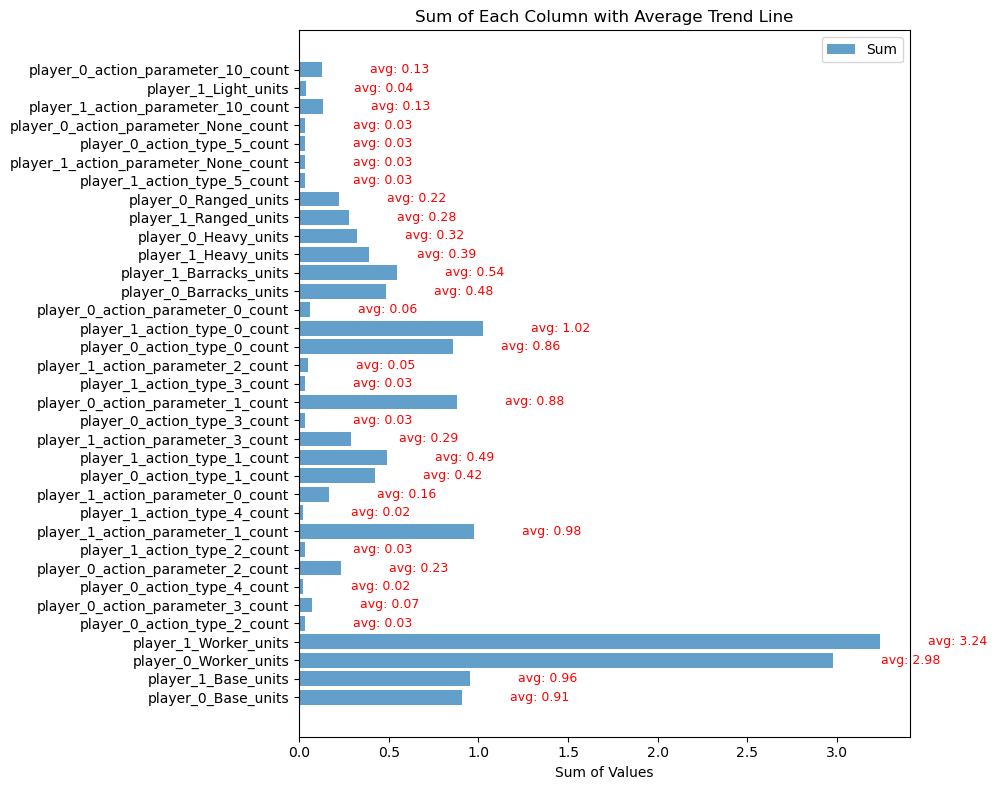

In [80]:
tournament_24.ClusterTraceChart(1)
tournament_24.ClusterTraceChart(2)

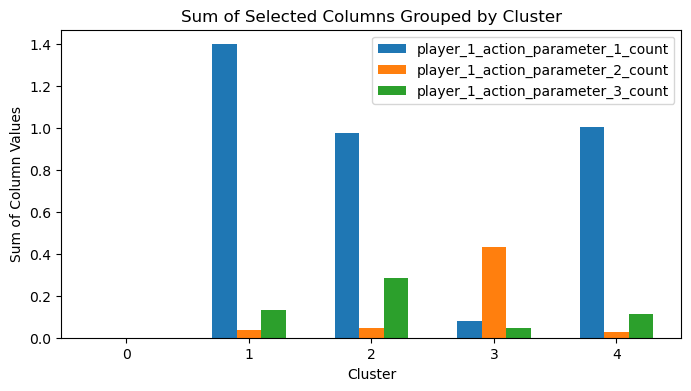

In [81]:
tournament_24.AttributeAvgByCluster(["player_1_action_parameter_1_count", "player_1_action_parameter_2_count", "player_1_action_parameter_3_count"])

### Tournament 24 mini

C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


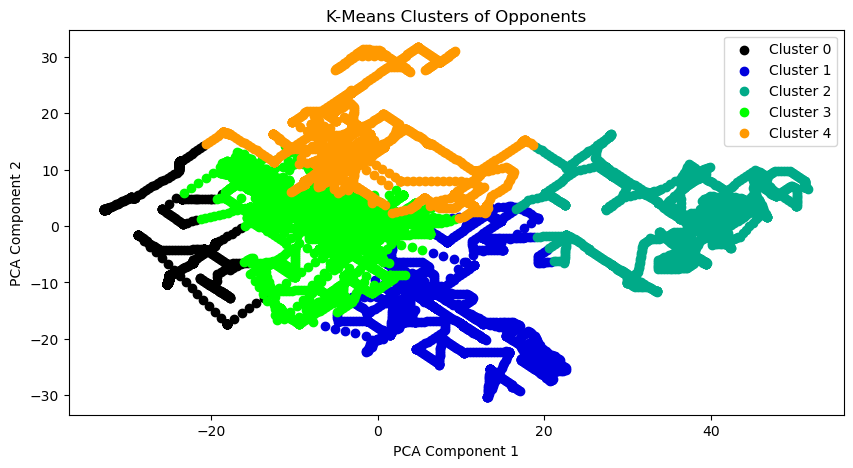

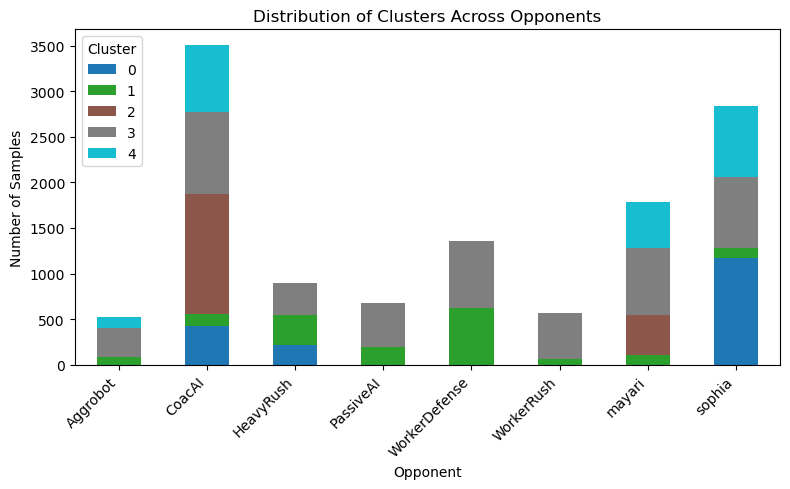

CPU times: total: 1.22 s
Wall time: 8.32 s


In [156]:
%%time
tournament_24_mini = TournamentAnalysis("tournament_24", 0.0025)
tournament_24_mini.preprocess(15)
tournament_24_mini.cluster(5)
tournament_24_mini.clusterBarchart(5, (8, 5))

(4821, 15, 38)


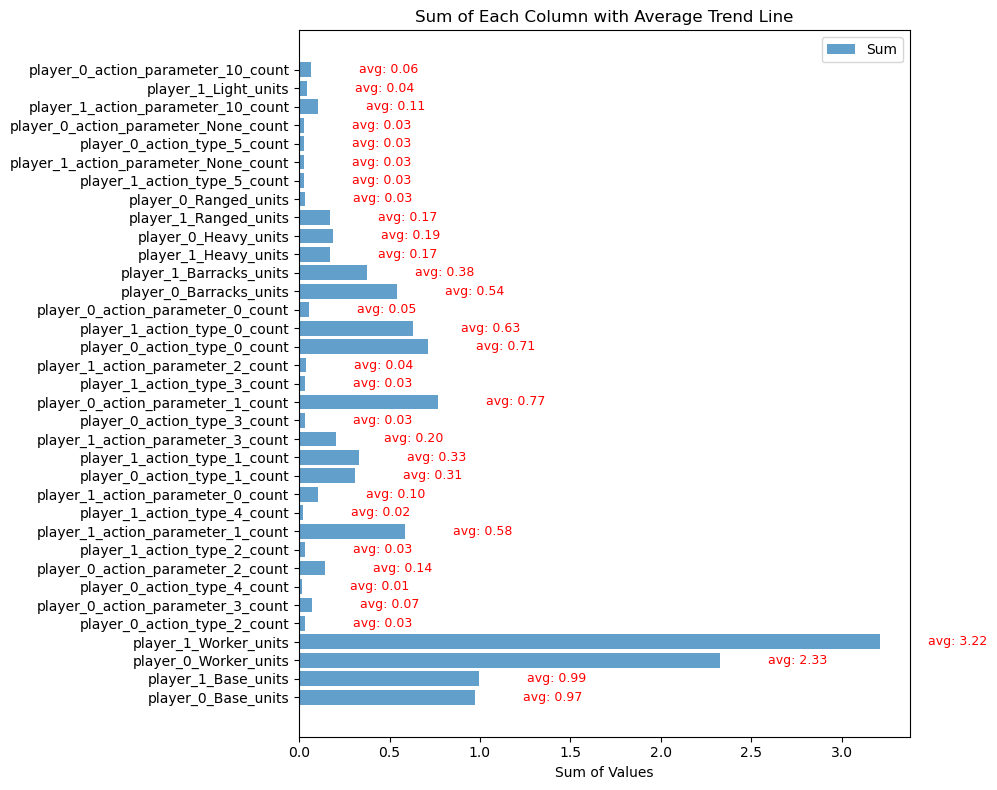

(1747, 15, 38)


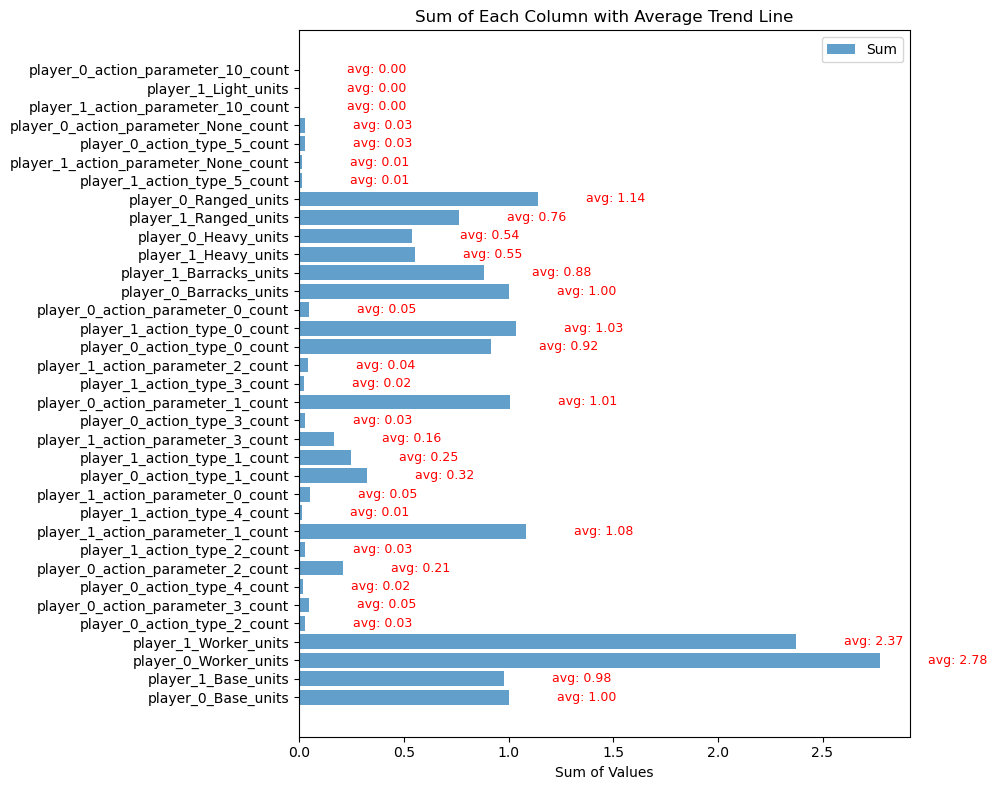

In [88]:
tournament_24_mini.ClusterTraceChart(3)
tournament_24_mini.ClusterTraceChart(2)

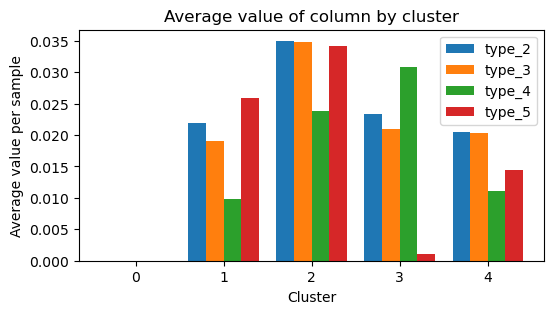

In [176]:
tournament_24.AttributeAvgByCluster([
    #"player_1_action_type_0_count", 
    #"player_1_action_type_1_count", 
    "player_1_action_type_2_count", 
    "player_1_action_type_3_count", 
    "player_1_action_type_4_count", 
    "player_1_action_type_5_count"
], (6, 3))

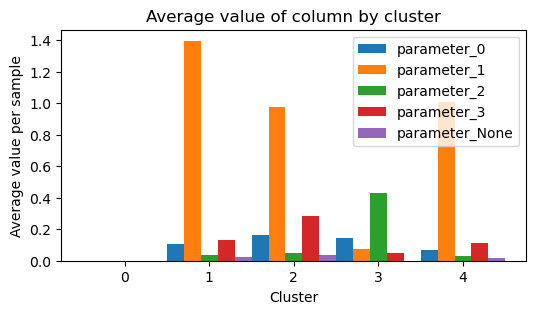

In [188]:
tournament_24.AttributeAvgByCluster([
    "player_1_action_parameter_0_count", 
    "player_1_action_parameter_1_count", 
    #"player_1_action_parameter_10_count", 
    "player_1_action_parameter_2_count", 
    "player_1_action_parameter_3_count", 
    "player_1_action_parameter_None_count"
], (6, 3))

,time,player_0_resources,player_1_resources,player_0_Base_units,player_1_Base_units,player_0_Worker_units,player_1_Worker_units,opponent,game_id,player_0_action_type_2_count,...,player_0_Ranged_units,player_1_action_type_5_count,player_1_action_parameter_None_count,player_0_action_type_5_count,player_0_action_parameter_None_count,player_1_action_parameter_10_count,player_1_Light_units,player_0_action_parameter_10_count,player_0_Light_units,cluster
0,0,5,5,1.0,1.0,1.0,1.0,CoacAI,0-vs-0-0-0.zip,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,0,5,5,1.0,1.0,1.0,1.0,CoacAI,0-vs-0-0-0.zip,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,20,5,5,1.0,1.0,1.0,1.0,CoacAI,0-vs-0-0-0.zip,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,30,5,5,1.0,1.0,1.0,1.0,CoacAI,0-vs-0-0-0.zip,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,40,6,6,1.0,1.0,1.0,1.0,CoacAI,0-vs-0-0-0.zip,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101681,1950,0,1,0.0,1.0,1.0,8.0,WorkerDefense,7-vs-7-0-49.zip,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,NaN
2101682,1955,0,1,0.0,1.0,1.0,8.0,WorkerDefense,7-vs-7-0-49.zip,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2101683,1960,0,1,0.0,1.0,1.0,8.0,WorkerDefense,7-vs-7-0-49.zip,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,NaN
2101684,1965,0,1,0.0,1.0,1.0,8.0,WorkerDefense,7-vs-7-0-49.zip,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [70]:
print(len(tournament_24.X_columns))
tournament_24.X_columns

38


['player_0_resources',
 'player_1_resources',
 'player_0_Base_units',
 'player_1_Base_units',
 'player_0_Worker_units',
 'player_1_Worker_units',
 'player_0_action_type_2_count',
 'player_0_action_parameter_3_count',
 'player_0_action_type_4_count',
 'player_0_action_parameter_2_count',
 'player_1_action_type_2_count',
 'player_1_action_parameter_1_count',
 'player_1_action_type_4_count',
 'player_1_action_parameter_0_count',
 'player_0_action_type_1_count',
 'player_1_action_type_1_count',
 'player_1_action_parameter_3_count',
 'player_0_action_type_3_count',
 'player_0_action_parameter_1_count',
 'player_1_action_type_3_count',
 'player_1_action_parameter_2_count',
 'player_0_action_type_0_count',
 'player_1_action_type_0_count',
 'player_0_action_parameter_0_count',
 'player_0_Barracks_units',
 'player_1_Barracks_units',
 'player_1_Heavy_units',
 'player_0_Heavy_units',
 'player_1_Ranged_units',
 'player_0_Ranged_units',
 'player_1_action_type_5_count',
 'player_1_action_parameter_N

In [142]:
n = 2
figsize=(10, 8)
traces = tournament_24.GetXByCluster(n)
print(traces.shape)

(1763, 30, 38)


In [154]:


# Exclude the two columns related to player total resources
column_names_filtered = tournament_24.X_columns[2:-1]
X_filtered = traces[:,:, 2:-1]
X_filtered.shape

(1763, 30, 35)

In [148]:

# Sum the values across all windows and timesteps for each column
column_sums = X_filtered.sum(axis=(0, 1))

# Calculate the average for each column
column_averages = X_filtered.mean(axis=(0, 1))

print(column_sums.shape)
print(column_averages.shape)

(38,)
(38,)


In [ ]:



# Plotting the horizontal bar chart
plt.figure(figsize=figsize)
y_pos = np.arange(len(column_names_filtered))

plt.barh(y_pos, column_sums, align='center', alpha=0.7, label='Sum')
plt.plot(column_averages, y_pos, 'r--', label='Average', marker='o')

# Add inline labels for the average values
for i, avg in enumerate(column_averages):
    plt.text(avg, y_pos[i], f'            avg: {avg:.2f}', color='red', va='center', ha='left', fontsize=9)

# Add labels and title
plt.yticks(y_pos, column_names_filtered)
plt.xlabel('Sum of Values')
plt.title('Sum of Each Column with Average Trend Line')

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()